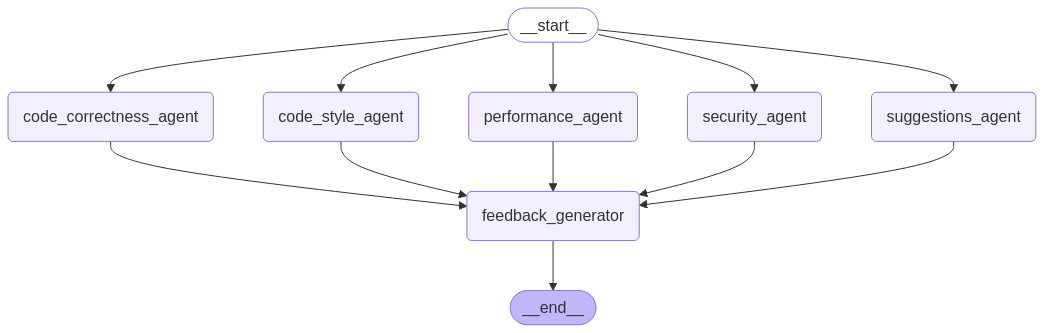

In [18]:
from typing import Annotated, Dict, List
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from langgraph.graph.message import add_messages

# Define state structure
class ReviewState(TypedDict):
    messages: Annotated[list, add_messages]
    code_correctness: List[str]
    code_style: List[str] 
    performance: List[str]
    security: List[str]
    other_suggestions: List[str]
    final_feedback: Dict

# Initialize agents with specific prompts
llm = ChatOllama(model="llama3.1")

def code_correctness_agent(state: ReviewState):
    prompt = "Review the code for logical correctness, syntax errors and bugs."
    response = llm.invoke(prompt + str(state["messages"]))
    return {"code_correctness": [response.content]}

def code_style_agent(state: ReviewState):
    prompt = "Review the code for style guidelines, readability and best practices."
    response = llm.invoke(prompt + str(state["messages"]))
    return {"code_style": [response.content]}

def performance_agent(state: ReviewState):
    prompt = "Review the code for performance optimizations and efficiency improvements."
    response = llm.invoke(prompt + str(state["messages"]))
    return {"performance": [response.content]}

def security_agent(state: ReviewState):
    prompt = "Review the code for security vulnerabilities and potential risks."
    response = llm.invoke(prompt + str(state["messages"]))
    return {"security": [response.content]}

def suggestions_agent(state: ReviewState):
    prompt = "Provide any additional suggestions for improving the code."
    response = llm.invoke(prompt + str(state["messages"]))
    return {"other_suggestions": [response.content]}

def feedback_generator(state: ReviewState):
    issues = {
        "Correctness": state["code_correctness"],
        "Style": state["code_style"],
        "Performance": state["performance"],
        "Security": state["security"],
        "Other": state["other_suggestions"]
    }

    prompt = f"Summarize the following code review feedback:\n{issues}"
    response = llm.invoke(prompt)

    return {
        "final_feedback": {
            "Issues Found": issues,
            "Summary": response.content,
            "Recommendations": "Consolidated recommendations based on the issues above."
        }
    }


# Build graph
graph = StateGraph(ReviewState)

# Add nodes
graph.add_node("code_correctness_agent", code_correctness_agent)
graph.add_node("code_style_agent", code_style_agent) 
graph.add_node("performance_agent", performance_agent)
graph.add_node("security_agent", security_agent)
graph.add_node("suggestions_agent", suggestions_agent)
graph.add_node("feedback_generator", feedback_generator)

# Parallel execution
graph.add_edge(START, "code_correctness_agent")
graph.add_edge(START, "code_style_agent")
graph.add_edge(START, "performance_agent")
graph.add_edge(START, "security_agent") 
graph.add_edge(START, "suggestions_agent")

# Merge into feedback
graph.add_edge("code_correctness_agent", "feedback_generator")
graph.add_edge("code_style_agent", "feedback_generator")
graph.add_edge("performance_agent", "feedback_generator")
graph.add_edge("security_agent", "feedback_generator")
graph.add_edge("suggestions_agent", "feedback_generator")

graph.add_edge("feedback_generator", END)

# Compile graph
workflow = graph.compile()

# Optional: Display the graph
from IPython.display import Image, display

try:
    display(Image(workflow.get_graph().draw_mermaid_png()))
except Exception:
    pass


In [19]:
def process_code_review(code_input: str):
    # Initialize the state with the code input
    initial_state = {
        "messages": [("user", code_input)],
        "code_correctness": [],
        "code_style": [],
        "performance": [],
        "security": [],
        "other_suggestions": [],
        "final_feedback": {}
    }
    
    # Run the workflow
    result = workflow.invoke(initial_state)
    
    # Print formatted results
    print("Code Review Results:")
    print("-" * 50)
    for category, feedback in result["final_feedback"]["Issues Found"].items():
        if feedback:
            print(f"\n{category}:")
            for item in feedback:
                print(f"- {item}")
    
    return result

In [20]:
# Test the code review system with a sample code
sample_code = """
def calculate_fibonacci(n):
    if n <= 0:
        return []
    elif n == 1:
        return [0]
    
    fib = [0, 1]
    for i in range(2, n):
        fib.append(fib[i-1] + fib[i-2])
    return fib

# Test the function
result = calculate_fibonacci(-1)
print(result)
"""

# Process the code review
review_results = process_code_review(sample_code)

Code Review Results:
--------------------------------------------------

Correctness:
- The code provided is for calculating Fibonacci numbers up to a given number `n`. However, there are several logical errors and bugs in this code:

### Syntax Errors and Bugs:

1. **Missing Colon**: The line `if n <= 0:` is missing a colon at the end.

2. **Incorrect Fibonacci Calculation**: In the Fibonacci sequence, each number is the sum of the two preceding ones, but your code incorrectly calculates it as `fib[i-1] + fib[i-2]`. It should be `fib[i-1] + fib[i-2]` instead of `fib.append(fib[i-1] + fib[i-2])`.

3. **Incorrect Handling for n = 0**: The Fibonacci sequence starts with `[0]`, not an empty list, when `n = 0`. So, the line `if n <= 0: return []` should be changed to `if n == 0: return [0]`.

4. **Incorrect Handling for n = 1**: When `n = 1`, your function should return `[0]`, not `[0, 1]`. The line `elif n == 1: return [0]` should remain the same.

5. **Range in Loop**: In the loop where 

In [22]:
review_results

{'messages': [HumanMessage(content='\ndef calculate_fibonacci(n):\n    if n <= 0:\n        return []\n    elif n == 1:\n        return [0]\n    \n    fib = [0, 1]\n    for i in range(2, n):\n        fib.append(fib[i-1] + fib[i-2])\n    return fib\n\n# Test the function\nresult = calculate_fibonacci(-1)\nprint(result)\n', additional_kwargs={}, response_metadata={}, id='e2a94fc6-f676-4c45-b7fc-2a0badbee819')],
 'code_correctness': ['The code provided is for calculating Fibonacci numbers up to a given number `n`. However, there are several logical errors and bugs in this code:\n\n### Syntax Errors and Bugs:\n\n1. **Missing Colon**: The line `if n <= 0:` is missing a colon at the end.\n\n2. **Incorrect Fibonacci Calculation**: In the Fibonacci sequence, each number is the sum of the two preceding ones, but your code incorrectly calculates it as `fib[i-1] + fib[i-2]`. It should be `fib[i-1] + fib[i-2]` instead of `fib.append(fib[i-1] + fib[i-2])`.\n\n3. **Incorrect Handling for n = 0**: The

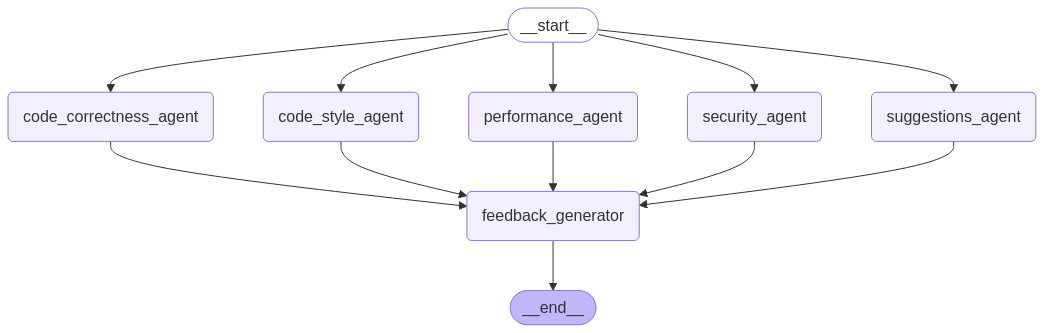

In [23]:
from IPython.display import Image, display

try:
    display(Image(workflow.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass